# PAID: (Prompt-guided) Attention Interpolation of Text-to-Image Diffusion

Author: Qiyuan He $^1$ Jinghao Wang $^2$ Ziwei Liu $^2$ Angela Yao $^1$

$^1$ National University of Singapore 

$^2$ S-Lab, Nanyang Technological University

In [1]:
from PIL import Image
import torch

from pipeline_interpolated_sdxl import InterpolationStableDiffusionXLPipeline
from prior import BetaPriorPipeline
from utils import image_grids


xl_pipe = InterpolationStableDiffusionXLPipeline.from_pretrained(
    "playgroundai/playground-v2.5-1024px-aesthetic", torch_dtype=torch.float16
)
generator = torch.cuda.manual_seed(1002)
dtype = torch.float16
xl_pipe.to("cuda", dtype=dtype)
beta_pipe = BetaPriorPipeline(xl_pipe)

size = xl_pipe.default_sample_size
latent = torch.randn((1, 4, size, size,), device="cuda", dtype=dtype, generator=generator)
latent_end = torch.randn((1, 4, size, size,), device="cuda", dtype=dtype, generator=generator)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/qiyuan/.conda/envs/AID/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Compositional Generation

Given a prompt that involves multiple components (e.g., "A dog driving a car"), we use the compositional description as a guidance prompt, with each related component (e.g., "A dog" and "A car") serving as the prompts at endpoints for interpolation. Under this setting, we apply PAID and then select the image from the interpolation sequence that achieves the highest CLIP score with respect to the compositional description.


In [2]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial
import numpy as np

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).astype("uint8")
    clip_score = clip_score_fn(torch.from_numpy(images_int).permute(0, 3, 1, 2), prompts).detach()
    return round(float(clip_score), 4)

  0%|          | 0/28 [00:00<?, ?it/s]

Alpha: 3 | Beta: 3 | Current Coefs: [0.0, 0.5, 1.0] | Current Distances: [tensor(0.2847), tensor(0.2263)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 4 / 5--------
Alpha: 1.9956268613656851 | Beta: 2.6254585956602887 | Current Coefs: [0.0, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2406), tensor(0.1384), tensor(0.2263)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 5 / 5--------
Alpha: 1.026638984823492 | Beta: 1.467110291027958 | Current Coefs: [0.0, 0.23373272705764855, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2145), tensor(0.0646), tensor(0.1384), tensor(0.2263)]
Optimal smooth path: [0, 1, 2, 3, 4]


/home/qiyuan/.conda/envs/AID/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[21.1045, 27.3538, 29.6282, 31.918, 24.6444]


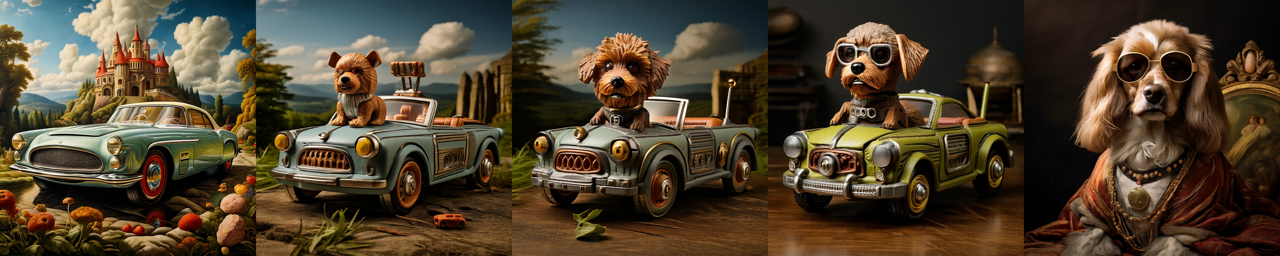

In [3]:
prompt_b = "masterpiece, best quality, very aesthetic, absurdres, A dog"
prompt_a = "masterpiece, best quality, very aesthetic, absurdres, A car"
guide_prompt = "masterpiece, best quality, very aesthetic, absurdres, the toy, named 'Dog-Car', is designed as a dog figure with car wheels instead of feet"
negative_prompt = "nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract]" # "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"
interpolation_size = 5
num_inference_steps = 28

images = beta_pipe.generate_interpolation(
    prompt_a,
    prompt_b,
    negative_prompt,
    latent_end,
    latent_end,
    num_inference_steps,
    exploration_size=int(interpolation_size),
    interpolation_size=interpolation_size,
    warmup_ratio=0.5,
    guide_prompt=guide_prompt,
    output_type="pil"
)

clip_scores = []
for i in range(len(images)):
    image = np.array(images[i])
    image = image[np.newaxis, ...]
    clip_score = calculate_clip_score(image, [guide_prompt])
    clip_scores.append(clip_score)
print(clip_scores)

show_image = image_grids(images, 1, interpolation_size).resize((interpolation_size * 256, 256))
show_image

  0%|          | 0/28 [00:00<?, ?it/s]

Alpha: 3 | Beta: 3 | Current Coefs: [0.0, 0.5, 1.0] | Current Distances: [tensor(0.3958), tensor(0.1831)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 4 / 7--------
Alpha: 2.192568565432823 | Beta: 3.12830816358587 | Current Coefs: [0.0, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2366), tensor(0.1356), tensor(0.1831)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 5 / 7--------
Alpha: 1.565419768748898 | Beta: 2.6613658119870984 | Current Coefs: [0.0, 0.23750115516776102, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2073), tensor(0.1359), tensor(0.1356), tensor(0.1831)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 6 / 7--------
Alpha: 0.9737738915047361 | Beta: 1.684619151490317 | Current Coefs: [0.0, 0.14244579832922633, 0.23750115516776102, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.1948), tensor(0.0200), tensor(0.1359), tensor(0.1356), tensor(0.1831)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 7 / 7--------
Alpha: 0.7072050634917169 | Beta: 1.1945923935492533 | Current Coefs: [0.0, 0.06801577044633908, 0.14244579832922633, 0.23750115516776102, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.1583), tensor(0.0373), tensor(0.0200), tensor(0.1359), tensor(0.1356), tensor(0.1831)]
Optimal smooth path: [0, 1, 4, 5, 6]


/home/qiyuan/.conda/envs/AID/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[25.3395, 26.6057, 30.4177, 32.1115, 22.2241]


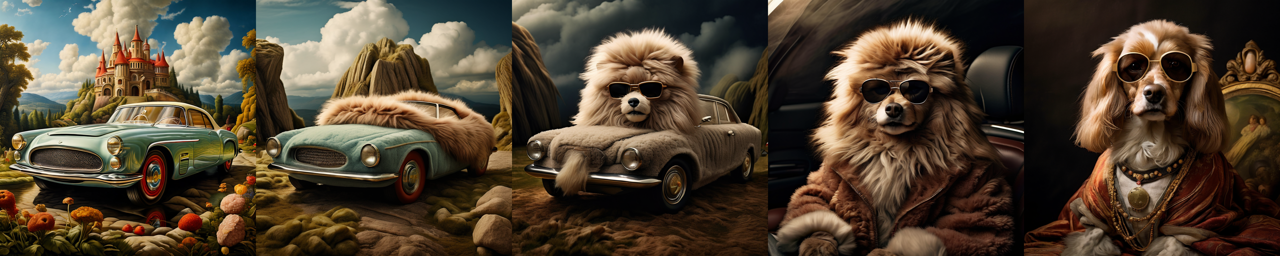

In [4]:
prompt_b = "masterpiece, best quality, very aesthetic, absurdres, A dog"
prompt_a = "masterpiece, best quality, very aesthetic, absurdres, A car"
guide_prompt = "masterpiece, best quality, very aesthetic, absurdres, A photo of a car with furry texture"
negative_prompt = "nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract]" # "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"
interpolation_size = 5
num_inference_steps = 28

images = beta_pipe.generate_interpolation(
    prompt_a,
    prompt_b,
    negative_prompt,
    latent_end,
    latent_end,
    num_inference_steps,
    exploration_size=int(interpolation_size * 1.5),
    interpolation_size=interpolation_size,
    warmup_ratio=0.5,
    guide_prompt=guide_prompt,
    output_type="pil"
)

clip_scores = []
for i in range(len(images)):
    image = np.array(images[i])
    image = image[np.newaxis, ...]
    clip_score = calculate_clip_score(image, [guide_prompt])
    clip_scores.append(clip_score)
print(clip_scores)

show_image = image_grids(images, 1, interpolation_size).resize((interpolation_size * 256, 256))
show_image

  0%|          | 0/28 [00:00<?, ?it/s]

Alpha: 3 | Beta: 3 | Current Coefs: [0.0, 0.5, 1.0] | Current Distances: [tensor(0.3623), tensor(0.2026)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 4 / 7--------
Alpha: 0.16226320830470248 | Beta: 0.3057202186787416 | Current Coefs: [0.0, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.3663), tensor(0.0285), tensor(0.2026)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 5 / 7--------
Alpha: 0.10222922021219105 | Beta: 0.20718153487963745 | Current Coefs: [0.0, 0.006448803538036884, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2607), tensor(0.1401), tensor(0.0285), tensor(0.2026)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 6 / 7--------
Alpha: 0.056373283427869784 | Beta: 0.10194219279650785 | Current Coefs: [0.0, 7.359357874507141e-06, 0.006448803538036884, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2397), tensor(0.0157), tensor(0.1401), tensor(0.0285), tensor(0.2026)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 7 / 7--------
Alpha: 0.028203566469857628 | Beta: 0.043879524205529305 | Current Coefs: [0.0, 3.364355262254198e-11, 7.359357874507141e-06, 0.006448803538036884, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.2424), tensor(0.0002), tensor(0.0157), tensor(0.1401), tensor(0.0285), tensor(0.2026)]
Optimal smooth path: [0, 2, 4, 5, 6]


/home/qiyuan/.conda/envs/AID/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[21.4978, 28.0701, 32.5532, 32.2021, 21.7761]


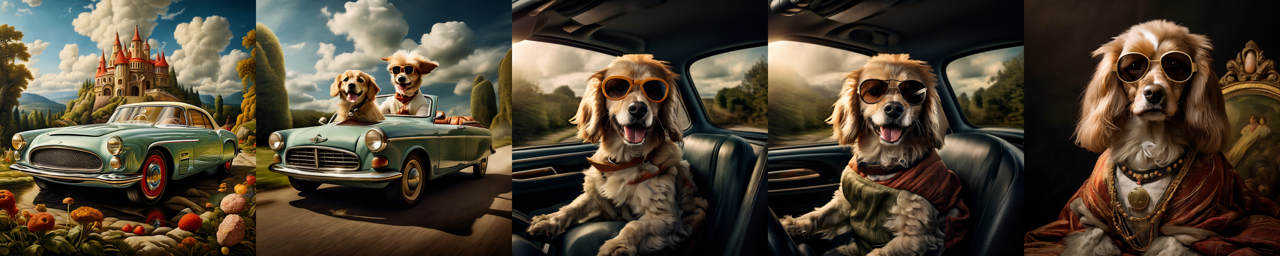

In [5]:
prompt_b = "masterpiece, best quality, very aesthetic, absurdres, A dog"
prompt_a = "masterpiece, best quality, very aesthetic, absurdres, A car"
guide_prompt = "masterpiece, best quality, very aesthetic, absurdres, A photo of a dog driving a car"
negative_prompt = "nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract]" # "deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality"
interpolation_size = 5
num_inference_steps = 28

images = beta_pipe.generate_interpolation(
    prompt_a,
    prompt_b,
    negative_prompt,
    latent_end,
    latent_end,
    num_inference_steps,
    exploration_size=int(interpolation_size * 1.5),
    interpolation_size=interpolation_size,
    warmup_ratio=0.5,
    guide_prompt=guide_prompt,
    output_type="pil"
)

clip_scores = []
for i in range(len(images)):
    image = np.array(images[i])
    image = image[np.newaxis, ...]
    clip_score = calculate_clip_score(image, [guide_prompt])
    clip_scores.append(clip_score)
print(clip_scores)

show_image = image_grids(images, 1, interpolation_size).resize((interpolation_size * 256, 256))
show_image

## Image Editing

We can use [P2P](https://github.com/google/prompt-to-prompt) or [EDICT](https://github.com/salesforce/EDICT) to firstly inverse the generation process of given image, and then set the endpoint condition as the original prompt and the edting prompt, respectively, to control the editing level of images.

#### Code: Coming soon...

## Image Morphing

Using IP-Adapter, we set the two images as the condition at the endpoints of the interpolation sequence for image morphing. Notice that the text prompt can be further added to refine the generated images at the endpoints.

In [6]:
xl_pipe = InterpolationStableDiffusionXLPipeline.from_pretrained(
    "RunDiffusion/Juggernaut-XL-v9", torch_dtype=torch.float16, variant="fp16"
)
xl_pipe.load_aid_ip_adapter("ozzygt/sdxl-ip-adapter", "", weight_name="ip-adapter-plus_sdxl_vit-h.safetensors")
generator = torch.cuda.manual_seed(1002)
dtype = torch.float16
xl_pipe.to("cuda", dtype=dtype)
beta_pipe = BetaPriorPipeline(xl_pipe)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Alpha: 3 | Beta: 3 | Current Coefs: [0.0, 0.5, 1.0] | Current Distances: [tensor(0.3277), tensor(0.1927)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 4 / 8--------
Alpha: 8.801473207131574 | Beta: 9.945036145271642 | Current Coefs: [0.0, 0.3594361647896471, 0.5, 1.0] | Current Distances: [tensor(0.0833), tensor(0.2137), tensor(0.1927)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 5 / 8--------
Alpha: 11.659199578802028 | Beta: 13.439827772831066 | Current Coefs: [0.0, 0.3594361647896471, 0.4353864935763017, 0.5, 1.0] | Current Distances: [tensor(0.0833), tensor(0.1235), tensor(0.1463), tensor(0.1927)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 6 / 8--------
Alpha: 9.941647633556693 | Beta: 10.987601701034402 | Current Coefs: [0.0, 0.3594361647896471, 0.4353864935763017, 0.5, 0.5558584225049237, 1.0] | Current Distances: [tensor(0.0833), tensor(0.1235), tensor(0.1463), tensor(0.0887), tensor(0.1397)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 7 / 8--------
Alpha: 14.446184205071038 | Beta: 15.91956044098884 | Current Coefs: [0.0, 0.3594361647896471, 0.4353864935763017, 0.46787712908406565, 0.5, 0.5558584225049237, 1.0] | Current Distances: [tensor(0.0833), tensor(0.1235), tensor(0.0889), tensor(0.1495), tensor(0.0887), tensor(0.1397)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 8 / 8--------
Alpha: 17.42687201417773 | Beta: 19.093748766092688 | Current Coefs: [0.0, 0.3594361647896471, 0.4353864935763017, 0.46787712908406565, 0.4837945079244001, 0.5, 0.5558584225049237, 1.0] | Current Distances: [tensor(0.0833), tensor(0.1235), tensor(0.0889), tensor(0.0873), tensor(0.1109), tensor(0.0887), tensor(0.1397)]
Optimal smooth path: [0, 2, 4, 6, 7]


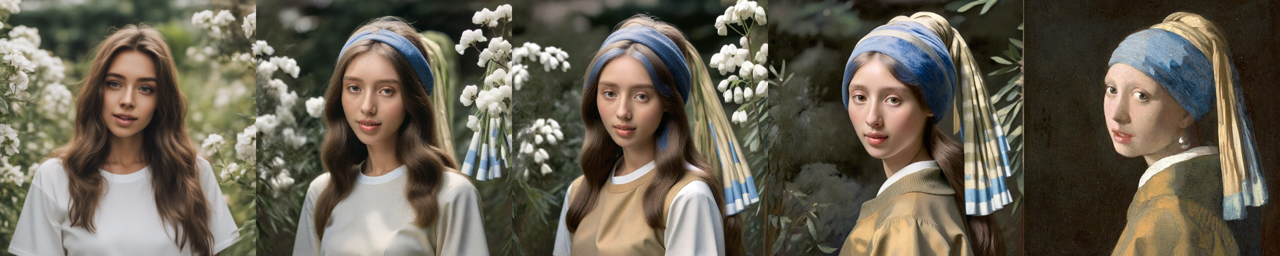

In [7]:
prompt_a = "masterpiece, best quality, A girl in the woods"
prompt_b = "masterpiece, best quality, Het meisje met de parel, by Vermeer"
negative_prompt = "nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract]"

image_a = Image.open("asset/girl.jpg")
image_b = Image.open("asset/vermeer.jpg")
images = beta_pipe.generate_interpolation(
    prompt_a,
    prompt_b,
    negative_prompt,
    latent,
    latent,
    image_start=image_a,
    image_end=image_b,
    num_inference_steps=28,
    exploration_size=8,
    interpolation_size=5,
    warmup_ratio=0.1
)
images[0] = image_a.resize((1024, 1024))
images[-1] = image_b.resize((1024, 1024))
show_image = image_grids(images, 1, 5).resize((5 * 256, 256))
show_image

## Image-control Generation

Given a text prompt and an image, we can better control the scale of IP-Adapter by AID. To achieve this, we set one endpoint as only using text prompt as condition while the other endpoint using both text and image condition. This provides smoother control over the scale of IP-Adapter.

In [8]:
xl_pipe.load_aid_ip_adapter("ozzygt/sdxl-ip-adapter", "", weight_name="ip-adapter-plus_sdxl_vit-h.safetensors", early="scale_control")

  0%|          | 0/28 [00:00<?, ?it/s]

Alpha: 1 | Beta: 1 | Current Coefs: [0.0, 0.5, 1.0] | Current Distances: [tensor(0.1709), tensor(0.1770)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 4 / 5--------
Alpha: 0.5071558521658623 | Beta: 0.521376299321523 | Current Coefs: [0.0, 0.5, 0.75, 1.0] | Current Distances: [tensor(0.1709), tensor(0.0569), tensor(0.1086)]


  0%|          | 0/28 [00:00<?, ?it/s]

--------Exploration: 5 / 5--------
Alpha: 0.653097892589661 | Beta: 0.7641519309574146 | Current Coefs: [0.0, 0.14808306111894698, 0.5, 0.75, 1.0] | Current Distances: [tensor(0.0877), tensor(0.1418), tensor(0.0569), tensor(0.1086)]
Optimal smooth path: [0, 1, 2, 3, 4]


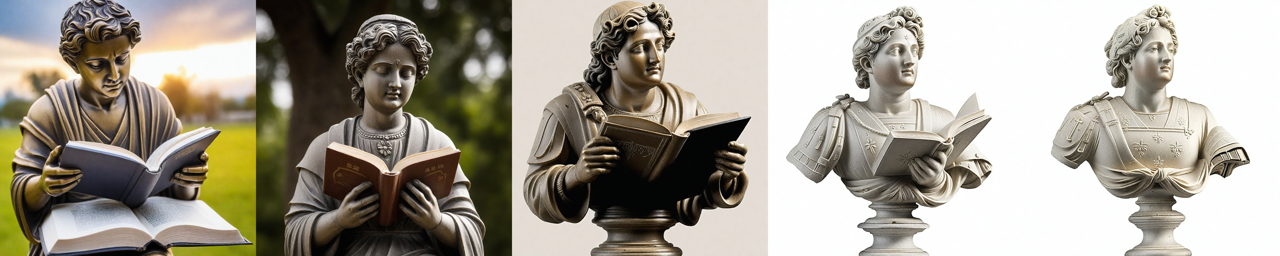

In [11]:
text_prompt = "best quality, high quality, a statue is reading the book"
image_prompt = Image.open("asset/statue.jpg")
negative_prompt = "nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract]"
images = beta_pipe.generate_interpolation(
    text_prompt,
    text_prompt, # same text prompt for controlling the impact of image prompt
    negative_prompt,
    latent,
    latent,
    num_inference_steps=28,
    exploration_size=5,
    interpolation_size=5,
    image_start=None, # no image prompt for the start point
    image_end=image_prompt,
    output_type="pil",
    warmup_ratio=0.3,
    init_alpha=1,
    init_beta=1
)
show_image = image_grids(images, 1, 5).resize((5 * 256, 256))
show_image
